In [5]:
import spot
import buddy
from spot.jupyter import display_inline, display
from IPython.core.display import HTML
spot.setup(show_default='.a')

In [2]:
# LTL2DBA09
formula = "((((G (F (p))) || (G (F (q)))) || (G (F (r)))) <-> (G (F (acc))))"
inputs = ["r","q","p"]
outputs = ["acc"]

# Automaton Construction

In [6]:
f = spot.formula(formula); nba = f.translate()
display_inline(nba)

# Synthesis the Formula

game has 10 states and 19 edges
output propositions are: acc


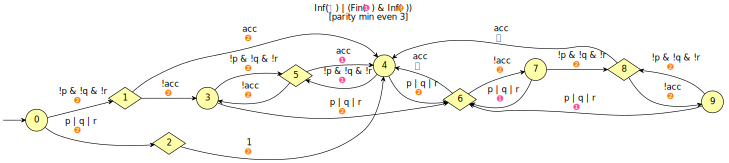

In [11]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET # Use LAR algorithm

game = spot.ltl_to_game(formula, outputs, si)
print("game has", game.num_states(), "states and", game.num_edges(), "edges")
print("output propositions are:", ", ".join(spot.get_synthesis_output_aps(game)))
display(game)

Found a solution: True


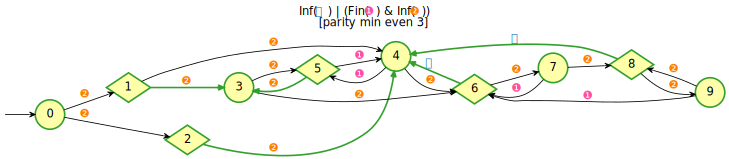

In [12]:
print("Found a solution:", spot.solve_game(game, si))
spot.highlight_strategy(game)
game.show('.g')

### Strategy Mealy Machine

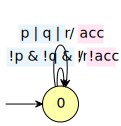

In [13]:
mealy = spot.solved_game_to_mealy(game, si)
spot.simplify_mealy_here(mealy, si.minimize_lvl, False)
display(mealy)